In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms 
import matplotlib.pyplot as plt
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from tqdm import tqdm
from IPython.display import display
from PIL import Image
import torch.nn.functional as F
from torchvision import models
import pandas as pd
import seaborn as sns

# Data augmentation and normalization for training
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),       # Random crop with padding
    transforms.RandomHorizontalFlip(),          # Random horizontal flip
    transforms.ToTensor(),                      # Convert image to PyTorch tensor
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010))  # Normalize with CIFAR-10 stats
])

# Normalization only for test (no augmentation)
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010))
])

# Load CIFAR-10 training dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)

# DataLoader for training – shuffles data and loads in batches
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=True, num_workers=2)

# Load CIFAR-10 test dataset
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)

# DataLoader for testing – no shuffling
testloader = torch.utils.data.DataLoader(testset, batch_size=100,
                                         shuffle=False, num_workers=2)


In [3]:
classes = ['airplane', 'automobile', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


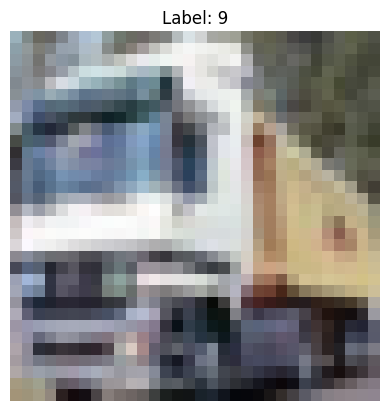

In [ ]:
# Load CIFAR-10 without any transforms to get raw PIL images
trainset = torchvision.datasets.CIFAR10(root="./data", train=True, transform=None, download=False)

# Get the first image and its label
img, label = trainset[1]

# Display the image using matplotlib
plt.imshow(img)
plt.title(f"Label: {label}")
plt.axis("off")
plt.show()

Teacher = Resnet-50

Student = Resnet-18

In [ ]:
# Teacher Model – ResNet-50 with forward hooks to extract attention maps
class TeacherModel(nn.Module):
    def __init__(self):
        super(TeacherModel, self).__init__()
        self.model = models.resnet50(pretrained=True)  # Load pretrained ResNet-50
        self.attention_maps = {}  # Store intermediate layer outputs
        self._register_hooks()

    def _register_hooks(self):
        # Register hooks on selected layers
        def save_activation(name):
            def hook(model, input, output):
                self.attention_maps[name] = output.detach()
            return hook

        self.model.layer1.register_forward_hook(save_activation('layer1'))
        self.model.layer2.register_forward_hook(save_activation('layer2'))
        self.model.layer3.register_forward_hook(save_activation('layer3'))

    def forward(self, x):
        self.attention_maps = {}  # Clear previous activations
        out = self.model(x)
        return out, self.attention_maps

# Student Model – ResNet-18 adapted for CIFAR-10 with hooks
class StudentModel(nn.Module):
    def __init__(self):
        super(StudentModel, self).__init__()
        self.model = models.resnet18(pretrained=False)

        self.model.maxpool = nn.Identity()  # Remove maxpool to preserve spatial size
        self.attention_maps = {}
        self._register_hooks()

    def _register_hooks(self):
        # Register hooks on selected layers
        def save_activation(name):
            def hook(model, input, output):
                self.attention_maps[name] = output.detach()
            return hook

        self.model.layer1.register_forward_hook(save_activation('layer1'))
        self.model.layer2.register_forward_hook(save_activation('layer2'))
        self.model.layer3.register_forward_hook(save_activation('layer3'))

    def forward(self, x):
        self.attention_maps = {}  # Clear previous activations
        out = self.model(x)
        return out, self.attention_maps

# Instantiate models and move to device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
teacher = TeacherModel().to(device)
student = StudentModel().to(device)

teacher, student


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


(TeacherModel(
   (model): ResNet(
     (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
     (layer1): Sequential(
       (0): Bottleneck(
         (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
         (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
         (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
         (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         (relu): ReLU(inplace=True)
         (downsample): Seq

Teacher training


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Train the model for one epoch
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in tqdm(dataloader, desc="Train", leave=False):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        # Support both student/teacher models (may return tuple with attention maps)
        out = model(inputs)
        if isinstance(out, tuple):
            outputs, _ = out  # Discard attention maps
        else:
            outputs = out

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = outputs.max(1)  # Get predicted class indices
        correct += preds.eq(labels).sum().item()
        total += labels.size(0)

    return running_loss / total, correct / total  # Return average loss and accuracy


In [7]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            out = model(inputs)
            if isinstance(out, tuple):
                outputs, _ = out
            else:
                outputs = out

            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, preds = outputs.max(1)
            correct += preds.eq(labels).sum().item()
            total += labels.size(0)

    return running_loss / total, correct / total


In [8]:
def train_student_kd(student, teacher, dataloader, criterion_cls, criterion_kd, optimizer, alpha, device):
    student.train()
    teacher.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in tqdm(dataloader, desc="KD Train", leave=False):
        inputs, labels = inputs.to(device), labels.to(device)

        # forward
        with torch.no_grad():
            teacher_logits, _ = teacher(inputs)
        student_logits, _ = student(inputs)

        # losses
        loss_cls = criterion_cls(student_logits, labels)
        loss_kd = criterion_kd(
            nn.functional.log_softmax(student_logits / 4, dim=1),
            nn.functional.softmax(teacher_logits / 4, dim=1)
        )
        loss = alpha * loss_cls + (1 - alpha) * loss_kd

        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = student_logits.max(1)
        correct += preds.eq(labels).sum().item()
        total += labels.size(0)

    return running_loss / total, correct / total


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(teacher.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
scheduler = StepLR(optimizer, step_size=30, gamma=0.1)
epochs = 30
best_acc = 0.0

for epoch in range(epochs):
    print(f"\n🌱 Epoch {epoch + 1}/{epochs}")
    train_loss, train_acc = train_one_epoch(teacher, trainloader, criterion, optimizer, device)
    val_loss, val_acc = evaluate(teacher, testloader, criterion, device)
    scheduler.step()

    print(f"🟢 Train Loss: {train_loss:.4f} | Accuracy: {train_acc:.4f}")
    print(f"🔵 Test  Loss: {val_loss:.4f} | Accuracy: {val_acc:.4f}")

    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(teacher.state_dict(), "best_teacher.pth")
        print("💾 נשמר המורה הטוב ביותר ✅")

print(f"\n🎉 האימון הסתיים! דיוק מירבי: {best_acc:.4f}")



🌱 Epoch 1/30


🟢 Train Loss: 1.8467 | Accuracy: 0.4324
🔵 Test  Loss: 1.5791 | Accuracy: 0.5197
💾 נשמר המורה הטוב ביותר ✅

🌱 Epoch 2/30


🟢 Train Loss: 1.3849 | Accuracy: 0.5357
🔵 Test  Loss: 1.3452 | Accuracy: 0.5422
💾 נשמר המורה הטוב ביותר ✅

🌱 Epoch 3/30


🟢 Train Loss: 1.6318 | Accuracy: 0.4445
🔵 Test  Loss: 3.9043 | Accuracy: 0.5033

🌱 Epoch 4/30


🟢 Train Loss: 1.2204 | Accuracy: 0.5778
🔵 Test  Loss: 2.7358 | Accuracy: 0.6226
💾 נשמר המורה הטוב ביותר ✅

🌱 Epoch 5/30


🟢 Train Loss: 1.0363 | Accuracy: 0.6447
🔵 Test  Loss: 0.9456 | Accuracy: 0.6720
💾 נשמר המורה הטוב ביותר ✅

🌱 Epoch 6/30


🟢 Train Loss: 0.8675 | Accuracy: 0.6927
🔵 Test  Loss: 0.7930 | Accuracy: 0.7245
💾 נשמר המורה הטוב ביותר ✅

🌱 Epoch 7/30


🟢 Train Loss: 0.7978 | Accuracy: 0.7211
🔵 Test  Loss: 0.7330 | Accuracy: 0.7436
💾 נשמר המורה הטוב ביותר ✅

🌱 Epoch 8/30


🟢 Train Loss: 0.7066 | Accuracy: 0.7525
🔵 Test  Loss: 0.6922 | Accuracy: 0.7601
💾 נשמר המורה הטוב ביותר ✅

🌱 Epoch 9/30


🟢 Train Loss: 0.6505 | Accuracy: 0.7739
🔵 Test  Loss: 0.6498 | Accuracy: 0.7755
💾 נשמר המורה הטוב ביותר ✅

🌱 Epoch 10/30


🟢 Train Loss: 0.6135 | Accuracy: 0.7866
🔵 Test  Loss: 0.6126 | Accuracy: 0.7876
💾 נשמר המורה הטוב ביותר ✅

🌱 Epoch 11/30


🟢 Train Loss: 0.5828 | Accuracy: 0.7975
🔵 Test  Loss: 0.6336 | Accuracy: 0.7848

🌱 Epoch 12/30


🟢 Train Loss: 0.5539 | Accuracy: 0.8072
🔵 Test  Loss: 0.5946 | Accuracy: 0.7970
💾 נשמר המורה הטוב ביותר ✅

🌱 Epoch 13/30


🟢 Train Loss: 0.5253 | Accuracy: 0.8172
🔵 Test  Loss: 0.5412 | Accuracy: 0.8171
💾 נשמר המורה הטוב ביותר ✅

🌱 Epoch 14/30


🟢 Train Loss: 0.5201 | Accuracy: 0.8199
🔵 Test  Loss: 0.6911 | Accuracy: 0.7684

🌱 Epoch 15/30


🟢 Train Loss: 0.4966 | Accuracy: 0.8285
🔵 Test  Loss: 0.5480 | Accuracy: 0.8157

🌱 Epoch 16/30


🟢 Train Loss: 0.4653 | Accuracy: 0.8379
🔵 Test  Loss: 0.5277 | Accuracy: 0.8208
💾 נשמר המורה הטוב ביותר ✅

🌱 Epoch 17/30


🟢 Train Loss: 0.4451 | Accuracy: 0.8450
🔵 Test  Loss: 0.5274 | Accuracy: 0.8206

🌱 Epoch 18/30


🟢 Train Loss: 0.4309 | Accuracy: 0.8486
🔵 Test  Loss: 0.5304 | Accuracy: 0.8267
💾 נשמר המורה הטוב ביותר ✅

🌱 Epoch 19/30


🟢 Train Loss: 0.4211 | Accuracy: 0.8530
🔵 Test  Loss: 0.5106 | Accuracy: 0.8305
💾 נשמר המורה הטוב ביותר ✅

🌱 Epoch 20/30


🟢 Train Loss: 0.4049 | Accuracy: 0.8575
🔵 Test  Loss: 0.4923 | Accuracy: 0.8339
💾 נשמר המורה הטוב ביותר ✅

🌱 Epoch 21/30


🟢 Train Loss: 0.3900 | Accuracy: 0.8631
🔵 Test  Loss: 0.4824 | Accuracy: 0.8392
💾 נשמר המורה הטוב ביותר ✅

🌱 Epoch 22/30


🟢 Train Loss: 0.3858 | Accuracy: 0.8647
🔵 Test  Loss: 0.5012 | Accuracy: 0.8338

🌱 Epoch 23/30


🟢 Train Loss: 0.3726 | Accuracy: 0.8697
🔵 Test  Loss: 0.4969 | Accuracy: 0.8343

🌱 Epoch 24/30


🟢 Train Loss: 0.3592 | Accuracy: 0.8738
🔵 Test  Loss: 0.5083 | Accuracy: 0.8305

🌱 Epoch 25/30


🟢 Train Loss: 0.3521 | Accuracy: 0.8769
🔵 Test  Loss: 0.4938 | Accuracy: 0.8363

🌱 Epoch 26/30


🟢 Train Loss: 0.3482 | Accuracy: 0.8778
🔵 Test  Loss: 0.5001 | Accuracy: 0.8358

🌱 Epoch 27/30


🟢 Train Loss: 0.3469 | Accuracy: 0.8784
🔵 Test  Loss: 0.4766 | Accuracy: 0.8461
💾 נשמר המורה הטוב ביותר ✅

🌱 Epoch 28/30


🟢 Train Loss: 0.3309 | Accuracy: 0.8843
🔵 Test  Loss: 0.4840 | Accuracy: 0.8377

🌱 Epoch 29/30


🟢 Train Loss: 0.3289 | Accuracy: 0.8838
🔵 Test  Loss: 0.4822 | Accuracy: 0.8409

🌱 Epoch 30/30


🟢 Train Loss: 0.3167 | Accuracy: 0.8888
🔵 Test  Loss: 0.4774 | Accuracy: 0.8425

🎉 האימון הסתיים! דיוק מירבי: 0.8461


In [ ]:
# Load trained teacher model from checkpoint
teacher = TeacherModel().to(device)
teacher.load_state_dict(torch.load("best_teacher.pth", map_location=device))  # Load saved weights
teacher.eval()  # Set model to evaluation mode


TeacherModel(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
       

In [ ]:

# Define transform to prepare image for ResNet (224x224 + normalization)
transform = transforms.Compose([
    transforms.Resize((224, 224)),             # Resize to match ResNet input size
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))       # Basic normalization (adjust if needed)
])

# Example: get an image and label from the test set
img, label = testset[25]
img_resized = transform(img)                   # Apply transform
input_tensor = img_resized.unsqueeze(0).to(device)  # Add batch dimension and move to device

# Forward pass through teacher model
with torch.no_grad():
    logits, attention_maps = teacher(input_tensor)


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128444 (\N{FRAME WITH PICTURE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


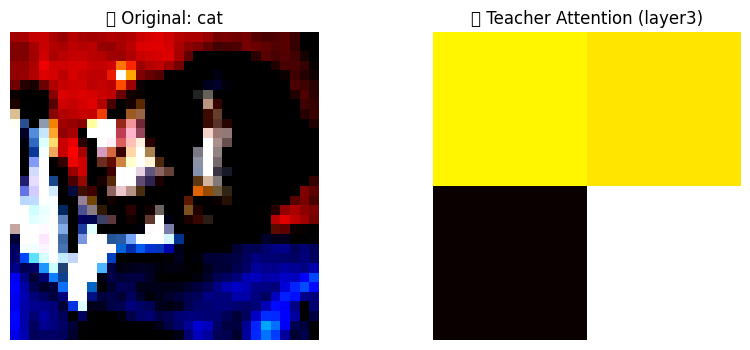

In [12]:
img, label = testset[0]
input_tensor = img.unsqueeze(0).to(device)

with torch.no_grad():
    logits, attention_maps = teacher(input_tensor)

# heatmap
feature_map = attention_maps["layer3"][0]
heatmap = feature_map.mean(0).cpu()

# plot both
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

axs[0].imshow(img.permute(1, 2, 0))
axs[0].set_title(f"🖼️ Original: {classes[label]}")
axs[0].axis("off")

axs[1].imshow(heatmap, cmap="hot")
axs[1].set_title("🔥 Teacher Attention (layer3)")
axs[1].axis("off")

plt.show()


In [13]:
def generate_causal_mask(attention_map, method="percentile", threshold=85):
    """
    attention_map: torch.Tensor of shape (H, W)
    method: "percentile" or "absolute"
    threshold: percentile value or absolute threshold

    Returns: binary mask of shape (H, W)
    """
    if method == "percentile":
        cutoff = torch.quantile(attention_map.flatten(), threshold / 100.0)
    elif method == "absolute":
        cutoff = threshold
    else:
        raise ValueError("Unsupported method")

    mask = (attention_map >= cutoff).float()
    return mask


In [ ]:
# Get the same image from the test set
img, label = testset[0]
input_tensor = img.unsqueeze(0).to(device)  # Add batch dimension and move to device

# Pass through teacher and student models
with torch.no_grad():
    teacher_logits, teacher_att = teacher(input_tensor)
    student_logits, student_att = student(input_tensor)

# Extract average attention map from layer3 for both models
teacher_map = teacher_att["layer3"][0].mean(0).cpu()  # [H, W] – average over channels
student_map = student_att["layer3"][0].mean(0).cpu()


/tmp/ipython-input-15-2771657849.py:21: UserWarning: Glyph 128444 (\N{FRAME WITH PICTURE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-15-2771657849.py:21: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-15-2771657849.py:21: UserWarning: Glyph 127891 (\N{GRADUATION CAP}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127891 (\N{GRADUATION CAP}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


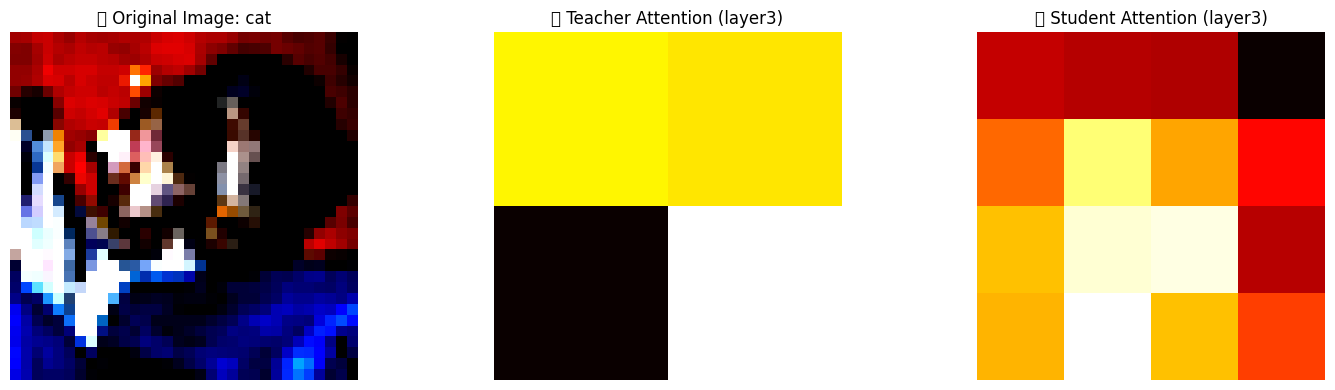

In [ ]:

# Plot the original image and attention maps from teacher and student
fig, axs = plt.subplots(1, 3, figsize=(15, 4))

# Show original input image
axs[0].imshow(img.permute(1, 2, 0))  # Convert from [C, H, W] to [H, W, C] for plotting
axs[0].set_title(f"Original Image: {classes[label]}")
axs[0].axis("off")

# Show teacher's attention map (layer3)
axs[1].imshow(teacher_map, cmap="hot")
axs[1].set_title("Teacher Attention (layer3)")
axs[1].axis("off")

# Show student's attention map (layer3)
axs[2].imshow(student_map, cmap="hot")
axs[2].set_title("Student Attention (layer3)")
axs[2].axis("off")

plt.tight_layout()
plt.show()


In [ ]:


def compare_attention_maps(teacher_att, student_att, layer="layer3"):
    """
    Compare attention maps of teacher and student at a specific layer,
    and print the Mean Squared Error (MSE) between them.
    """
    # Extract attention maps for the specified layer
    teacher_map = teacher_att[layer][0].mean(0).cpu()   # [H, W]
    student_map = student_att[layer][0].mean(0).cpu()   # [H', W']

    # Add batch and channel dimensions
    teacher_map = teacher_map.unsqueeze(0).unsqueeze(0)   # [1, 1, H, W]
    student_map = student_map.unsqueeze(0).unsqueeze(0)   # [1, 1, H', W']

    # Resize student map to match teacher map size
    student_map_resized = F.interpolate(student_map, size=teacher_map.shape[-2:], mode="bilinear", align_corners=False)

    # Flatten both maps to vectors
    teacher_vec = teacher_map.flatten()
    student_vec = student_map_resized.flatten()

    # Compute MSE loss
    mse_loss = F.mse_loss(student_vec, teacher_vec)
    print(f"📉 MSE בין המורה לתלמיד ({layer}): {mse_loss.item():.6f}")

    return mse_loss.item()


📉 MSE בין המורה לתלמיד (layer3): 0.608239


In [ ]:
def compare_attention_maps(teacher_att, student_att, layer="layer3"):
    """
    Compare attention maps of teacher and student at a specific layer,
    and print the Mean Squared Error (MSE) between them.
    """
    # Extract attention maps from the given layer
    teacher_map = teacher_att[layer][0].mean(0).cpu()   # [H, W]
    student_map = student_att[layer][0].mean(0).cpu()   # [H', W']

    # Add batch and channel dimensions
    teacher_map = teacher_map.unsqueeze(0).unsqueeze(0)   # [1, 1, H, W]
    student_map = student_map.unsqueeze(0).unsqueeze(0)   # [1, 1, H', W']

    # Resize student map to match teacher map
    student_map_resized = F.interpolate(student_map, size=teacher_map.shape[-2:], mode="bilinear", align_corners=False)

    # Flatten both maps
    teacher_vec = teacher_map.flatten()
    student_vec = student_map_resized.flatten()

    # Compute MSE loss
    mse_loss = F.mse_loss(student_vec, teacher_vec)
    print(f"📉 MSE בין המורה לתלמיד ({layer}): {mse_loss.item():.6f}")

    return mse_loss.item()


In [18]:
compare_attention_maps(teacher_att, student_att, layer="layer3")


📉 MSE בין המורה לתלמיד (layer3): 0.608239


0.6082385778427124

In [19]:
compare_attention_maps(teacher_att, student_att, layer="layer2")
compare_attention_maps(teacher_att, student_att, layer="layer1")


📉 MSE בין המורה לתלמיד (layer2): 0.538701
📉 MSE בין המורה לתלמיד (layer1): 0.585690


0.585690438747406

In [ ]:
def distillation_loss(student_logits, teacher_logits,
                      student_att, teacher_att,
                      labels, alpha=1.0, beta=10.0, layer="layer3"):
    """
    Loss משולב: CrossEntropy + MSE על מפות הקשב (attention)
    """

    # Cross-Entropy between student predictions and true labels
    ce_loss = F.cross_entropy(student_logits, labels)

    # Extract attention maps from specified layer
    t_map = teacher_att[layer][0].unsqueeze(0).mean(1)  # [1, H, W]
    s_map = student_att[layer][0].unsqueeze(0).mean(1)  # [1, H', W']

    # Resize student map to match teacher map size
    s_map_resized = F.interpolate(s_map.unsqueeze(1), size=t_map.shape[-2:], mode='bilinear', align_corners=False).squeeze(1)

    # Compute MSE between attention maps
    att_loss = F.mse_loss(s_map_resized, t_map)

    # Combine the losses
    total_loss = alpha * ce_loss + beta * att_loss
    return total_loss, ce_loss.item(), att_loss.item()


In [ ]:
def train_distill_epoch(student, teacher, dataloader, optimizer, device, alpha=1.0, beta=10.0):
    student.train()
    teacher.eval()

    total_loss, total_ce, total_att, correct, total = 0.0, 0.0, 0.0, 0, 0

    for inputs, labels in tqdm(dataloader, desc="Distill Training", leave=False):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        # Forward pass through teacher (no gradients)
        with torch.no_grad():
            t_logits, t_att = teacher(inputs)

        # Forward pass through student
        s_logits, s_att = student(inputs)

        # Compute combined distillation loss
        loss, ce, att = distillation_loss(s_logits, t_logits, s_att, t_att, labels, alpha, beta)

        loss.backward()
        optimizer.step()

        # Accumulate metrics
        total_loss += loss.item() * inputs.size(0)
        total_ce += ce * inputs.size(0)
        total_att += att * inputs.size(0)
        _, preds = s_logits.max(1)
        correct += preds.eq(labels).sum().item()
        total += labels.size(0)

    # Compute averages
    avg_loss = total_loss / total
    avg_ce = total_ce / total
    avg_att = total_att / total
    accuracy = correct / total

    print(f"📊 Loss: {avg_loss:.4f} | CE: {avg_ce:.4f} | ATT: {avg_att:.4f} | Acc: {accuracy:.4f}")
    return avg_loss, avg_ce, avg_att, accuracy


In [22]:
train_losses = []
ce_losses = []
att_losses = []
train_accuracies = []


In [ ]:
epochs = 25
optimizer = optim.SGD(student.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
scheduler = StepLR(optimizer, step_size=5, gamma=0.5)

for epoch in range(epochs):
    print(f"\n🌱 Epoch {epoch + 1}/{epochs}")
    loss, ce, att, acc = train_distill_epoch(student, teacher, trainloader, optimizer, device)

    # Save values for plotting later
    train_losses.append(loss)
    ce_losses.append(ce)
    att_losses.append(att)
    train_accuracies.append(acc)

    scheduler.step()



🌱 Epoch 1/25


📊 Loss: 8.0445 | CE: 1.7352 | ATT: 0.6309 | Acc: 0.3797

🌱 Epoch 2/25


📊 Loss: 7.7940 | CE: 1.3659 | ATT: 0.6428 | Acc: 0.5041

🌱 Epoch 3/25


📊 Loss: 7.6007 | CE: 1.1891 | ATT: 0.6412 | Acc: 0.5752

🌱 Epoch 4/25


📊 Loss: 7.1919 | CE: 1.0429 | ATT: 0.6149 | Acc: 0.6280

🌱 Epoch 5/25


📊 Loss: 6.9633 | CE: 0.9401 | ATT: 0.6023 | Acc: 0.6674

🌱 Epoch 6/25


📊 Loss: 6.4716 | CE: 0.7826 | ATT: 0.5689 | Acc: 0.7234

🌱 Epoch 7/25


📊 Loss: 6.1942 | CE: 0.7266 | ATT: 0.5468 | Acc: 0.7410

🌱 Epoch 8/25


📊 Loss: 6.1195 | CE: 0.6897 | ATT: 0.5430 | Acc: 0.7569

🌱 Epoch 9/25


📊 Loss: 5.9164 | CE: 0.6618 | ATT: 0.5255 | Acc: 0.7685

🌱 Epoch 10/25


📊 Loss: 5.7559 | CE: 0.6178 | ATT: 0.5138 | Acc: 0.7822

🌱 Epoch 11/25


📊 Loss: 5.6277 | CE: 0.5481 | ATT: 0.5080 | Acc: 0.8080

🌱 Epoch 12/25


📊 Loss: 5.4579 | CE: 0.5286 | ATT: 0.4929 | Acc: 0.8143

🌱 Epoch 13/25


📊 Loss: 5.5068 | CE: 0.5155 | ATT: 0.4991 | Acc: 0.8182

🌱 Epoch 14/25


📊 Loss: 5.4104 | CE: 0.4980 | ATT: 0.4912 | Acc: 0.8256

🌱 Epoch 15/25


📊 Loss: 5.2165 | CE: 0.4804 | ATT: 0.4736 | Acc: 0.8320

🌱 Epoch 16/25


📊 Loss: 5.3273 | CE: 0.4402 | ATT: 0.4887 | Acc: 0.8435

🌱 Epoch 17/25


📊 Loss: 5.1264 | CE: 0.4310 | ATT: 0.4695 | Acc: 0.8490

🌱 Epoch 18/25


📊 Loss: 5.2082 | CE: 0.4203 | ATT: 0.4788 | Acc: 0.8527

🌱 Epoch 19/25


📊 Loss: 5.1671 | CE: 0.4066 | ATT: 0.4760 | Acc: 0.8576

🌱 Epoch 20/25


📊 Loss: 5.0996 | CE: 0.4025 | ATT: 0.4697 | Acc: 0.8589

🌱 Epoch 21/25


📊 Loss: 4.9876 | CE: 0.3735 | ATT: 0.4614 | Acc: 0.8693

🌱 Epoch 22/25


📊 Loss: 4.9988 | CE: 0.3751 | ATT: 0.4624 | Acc: 0.8675

🌱 Epoch 23/25


📊 Loss: 4.9895 | CE: 0.3629 | ATT: 0.4627 | Acc: 0.8746

🌱 Epoch 24/25


📊 Loss: 5.0599 | CE: 0.3603 | ATT: 0.4700 | Acc: 0.8729

🌱 Epoch 25/25


📊 Loss: 4.9427 | CE: 0.3568 | ATT: 0.4586 | Acc: 0.8759


train_student_kd function (necessary for KD):

In [ ]:
def train_student_kd(student, teacher, dataloader, criterion_cls, criterion_kd, optimizer, alpha=0.5, device="cuda"):
    student.train()
    teacher.eval()

    running_correct = 0
    total = 0
    running_loss = 0.0

    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        with torch.no_grad():
            teacher_outputs, teacher_att = teacher(inputs)

        student_outputs, student_att = student(inputs)

        # Extract features from layer3
        t_feat = teacher_att["layer3"]
        s_feat = student_att["layer3"]

         # Resize student feature map if needed
        if s_feat.shape[2:] != t_feat.shape[2:]:
            s_feat = F.interpolate(s_feat, size=t_feat.shape[2:], mode='bilinear', align_corners=False)

        # Classification loss (student vs true labels)
        loss_cls = criterion_cls(student_outputs, labels)

        # --- Attention MSE Loss ---
        teacher_layer = teacher_att["layer3"]
        student_layer = student_att["layer3"]

        teacher_flat = teacher_layer.mean(dim=[2, 3])
        student_flat = student_layer.mean(dim=[2, 3])

        min_dim = min(teacher_flat.shape[1], student_flat.shape[1])
        teacher_flat = teacher_flat[:, :min_dim]
        student_flat = student_flat[:, :min_dim]

        loss_kd = criterion_kd(student_flat, teacher_flat)

        # Total Loss
        total_loss = alpha * loss_cls + (1 - alpha) * loss_kd



        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        _, preds = student_outputs.max(1)
        running_correct += preds.eq(labels).sum().item()
        total += labels.size(0)
        running_loss += total_loss.item() * inputs.size(0)

    avg_loss = running_loss / total
    acc = running_correct / total
    return avg_loss, acc




Group 1- Regular Student Training - Baseline


📘 Baseline Epoch 1/30


🔹 Train Acc: 0.3863 | 🔹 Val Acc: 0.5011
💾 שמירה של המודל עם הביצועים הטובים ביותר ✅

📘 Baseline Epoch 2/30


🔹 Train Acc: 0.5272 | 🔹 Val Acc: 0.5901
💾 שמירה של המודל עם הביצועים הטובים ביותר ✅

📘 Baseline Epoch 3/30


🔹 Train Acc: 0.5928 | 🔹 Val Acc: 0.6437
💾 שמירה של המודל עם הביצועים הטובים ביותר ✅

📘 Baseline Epoch 4/30


🔹 Train Acc: 0.6380 | 🔹 Val Acc: 0.6582
💾 שמירה של המודל עם הביצועים הטובים ביותר ✅

📘 Baseline Epoch 5/30


🔹 Train Acc: 0.6694 | 🔹 Val Acc: 0.6748
💾 שמירה של המודל עם הביצועים הטובים ביותר ✅

📘 Baseline Epoch 6/30


🔹 Train Acc: 0.6879 | 🔹 Val Acc: 0.6996
💾 שמירה של המודל עם הביצועים הטובים ביותר ✅

📘 Baseline Epoch 7/30


🔹 Train Acc: 0.7038 | 🔹 Val Acc: 0.6966

📘 Baseline Epoch 8/30


🔹 Train Acc: 0.7156 | 🔹 Val Acc: 0.7194
💾 שמירה של המודל עם הביצועים הטובים ביותר ✅

📘 Baseline Epoch 9/30


🔹 Train Acc: 0.7327 | 🔹 Val Acc: 0.7266
💾 שמירה של המודל עם הביצועים הטובים ביותר ✅

📘 Baseline Epoch 10/30


🔹 Train Acc: 0.7415 | 🔹 Val Acc: 0.7537
💾 שמירה של המודל עם הביצועים הטובים ביותר ✅

📘 Baseline Epoch 11/30


🔹 Train Acc: 0.7559 | 🔹 Val Acc: 0.7440

📘 Baseline Epoch 12/30


🔹 Train Acc: 0.7624 | 🔹 Val Acc: 0.7597
💾 שמירה של המודל עם הביצועים הטובים ביותר ✅

📘 Baseline Epoch 13/30


🔹 Train Acc: 0.7693 | 🔹 Val Acc: 0.7647
💾 שמירה של המודל עם הביצועים הטובים ביותר ✅

📘 Baseline Epoch 14/30


🔹 Train Acc: 0.7764 | 🔹 Val Acc: 0.7626

📘 Baseline Epoch 15/30


🔹 Train Acc: 0.7868 | 🔹 Val Acc: 0.7661
💾 שמירה של המודל עם הביצועים הטובים ביותר ✅

📘 Baseline Epoch 16/30


🔹 Train Acc: 0.7884 | 🔹 Val Acc: 0.7601

📘 Baseline Epoch 17/30


🔹 Train Acc: 0.7964 | 🔹 Val Acc: 0.7864
💾 שמירה של המודל עם הביצועים הטובים ביותר ✅

📘 Baseline Epoch 18/30


🔹 Train Acc: 0.8014 | 🔹 Val Acc: 0.7686

📘 Baseline Epoch 19/30


🔹 Train Acc: 0.8049 | 🔹 Val Acc: 0.7754

📘 Baseline Epoch 20/30


🔹 Train Acc: 0.8114 | 🔹 Val Acc: 0.7910
💾 שמירה של המודל עם הביצועים הטובים ביותר ✅

📘 Baseline Epoch 21/30


🔹 Train Acc: 0.8162 | 🔹 Val Acc: 0.7890

📘 Baseline Epoch 22/30


🔹 Train Acc: 0.8176 | 🔹 Val Acc: 0.7971
💾 שמירה של המודל עם הביצועים הטובים ביותר ✅

📘 Baseline Epoch 23/30


🔹 Train Acc: 0.8253 | 🔹 Val Acc: 0.7927

📘 Baseline Epoch 24/30


🔹 Train Acc: 0.8255 | 🔹 Val Acc: 0.7915

📘 Baseline Epoch 25/30


🔹 Train Acc: 0.8287 | 🔹 Val Acc: 0.7920

📘 Baseline Epoch 26/30


🔹 Train Acc: 0.8347 | 🔹 Val Acc: 0.8008
💾 שמירה של המודל עם הביצועים הטובים ביותר ✅

📘 Baseline Epoch 27/30


🔹 Train Acc: 0.8358 | 🔹 Val Acc: 0.7996

📘 Baseline Epoch 28/30


🔹 Train Acc: 0.8400 | 🔹 Val Acc: 0.8056
💾 שמירה של המודל עם הביצועים הטובים ביותר ✅

📘 Baseline Epoch 29/30


🔹 Train Acc: 0.8428 | 🔹 Val Acc: 0.8054

📘 Baseline Epoch 30/30


🔹 Train Acc: 0.8452 | 🔹 Val Acc: 0.7999


/tmp/ipython-input-25-3547353719.py:84: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-25-3547353719.py:84: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


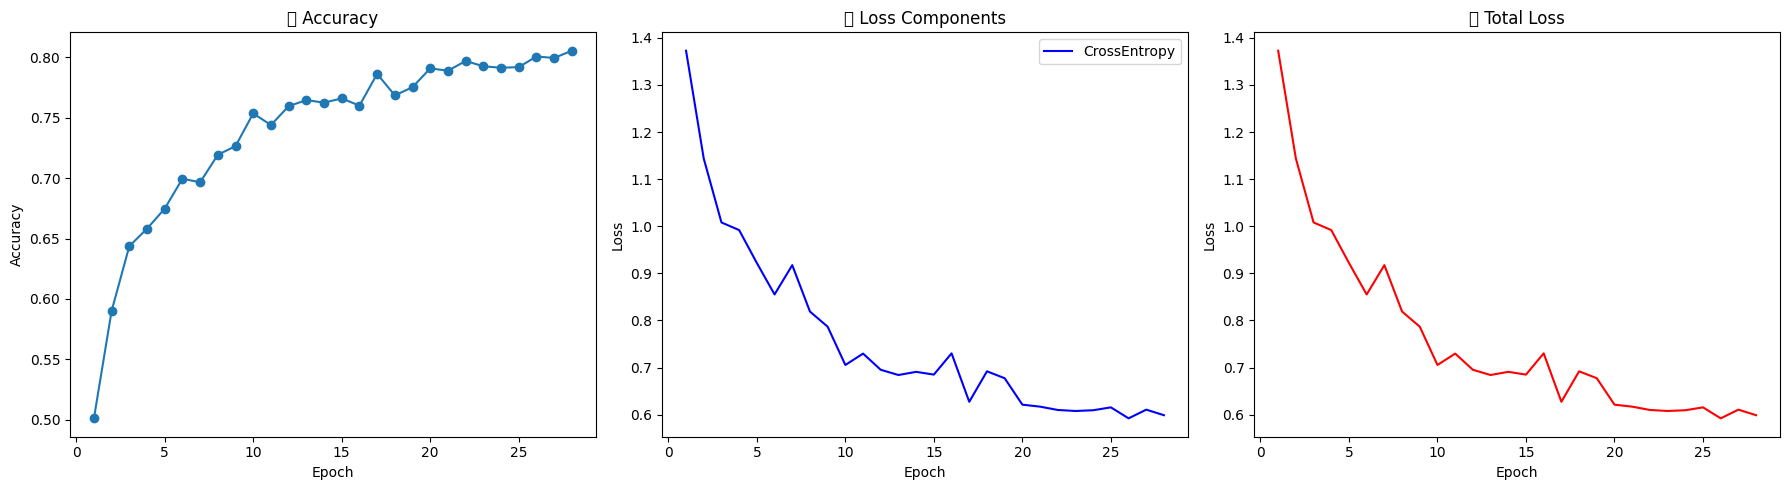

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

baseline_student = models.resnet18(pretrained=False, num_classes=10).to(device)
criterion_ce = nn.CrossEntropyLoss()
optimizer_base = optim.SGD(baseline_student.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
scheduler_base = StepLR(optimizer_base, step_size=30, gamma=0.1)

baseline_train_acc, baseline_val_acc = [], []
baseline_ce_loss, baseline_total_loss = [], []
epochs = 30

# ⏱️ Early stopping
best_val_acc = 0.0
patience = 5
epochs_no_improve = 0
best_epoch = 0

for epoch in range(epochs):
    print(f"\n📘 Baseline Epoch {epoch + 1}/{epochs}")
    train_loss, train_acc = train_one_epoch(baseline_student, trainloader, criterion_ce, optimizer_base, device)
    val_loss, val_acc = evaluate(baseline_student, testloader, criterion_ce, device)
    scheduler_base.step()

    baseline_train_acc.append(train_acc)
    baseline_val_acc.append(val_acc)
    baseline_ce_loss.append(val_loss)
    baseline_total_loss.append(val_loss)

    print(f"🔹 Train Acc: {train_acc:.4f} | 🔹 Val Acc: {val_acc:.4f}")

    # Early Stopping
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_epoch = epoch
        epochs_no_improve = 0
        torch.save(baseline_student.state_dict(), "best_baseline_student.pth")
        print("💾 שמירה של המודל עם הביצועים הטובים ביותר ✅")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"\n⏹️ עצירה מוקדמת ב־Epoch {epoch + 1} (לא חל שיפור במשך {patience} אפוקים)")
            break

# Keep results only up to best epoch
baseline_train_acc = baseline_train_acc[:best_epoch + 1]
baseline_val_acc = baseline_val_acc[:best_epoch + 1]
baseline_ce_loss = baseline_ce_loss[:best_epoch + 1]
baseline_total_loss = baseline_total_loss[:best_epoch + 1]

# Plot: Accuracy, CE loss, Total loss
plt.figure(figsize=(18, 5))

# Accuracy
plt.subplot(1, 3, 1)
plt.plot(range(1, best_epoch + 2), baseline_val_acc, marker='o')
plt.title("📈 Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

# Loss components – only CE in this baseline
plt.subplot(1, 3, 2)
plt.plot(range(1, best_epoch + 2), baseline_ce_loss, label="CrossEntropy", color='blue')
plt.title("📉 Loss Components")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Total Loss (same as CE in this case)
plt.subplot(1, 3, 3)
plt.plot(range(1, best_epoch + 2), baseline_total_loss, color='red')
plt.title("📉 Total Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.tight_layout()
plt.show()


Student training with KD - Group 2:


🎓 KD Epoch 1/30
📊 Train Acc: 0.3712 | Test Acc: 0.4693
💾 שמירה של המודל הטוב ביותר ✅

🎓 KD Epoch 2/30
📊 Train Acc: 0.4851 | Test Acc: 0.5311
💾 שמירה של המודל הטוב ביותר ✅

🎓 KD Epoch 3/30
📊 Train Acc: 0.5391 | Test Acc: 0.5669
💾 שמירה של המודל הטוב ביותר ✅

🎓 KD Epoch 4/30
📊 Train Acc: 0.5896 | Test Acc: 0.6264
💾 שמירה של המודל הטוב ביותר ✅

🎓 KD Epoch 5/30
📊 Train Acc: 0.6278 | Test Acc: 0.6603
💾 שמירה של המודל הטוב ביותר ✅

🎓 KD Epoch 6/30
📊 Train Acc: 0.6628 | Test Acc: 0.6685
💾 שמירה של המודל הטוב ביותר ✅

🎓 KD Epoch 7/30
📊 Train Acc: 0.6911 | Test Acc: 0.7074
💾 שמירה של המודל הטוב ביותר ✅

🎓 KD Epoch 8/30
📊 Train Acc: 0.7169 | Test Acc: 0.7146
💾 שמירה של המודל הטוב ביותר ✅

🎓 KD Epoch 9/30
📊 Train Acc: 0.7350 | Test Acc: 0.7424
💾 שמירה של המודל הטוב ביותר ✅

🎓 KD Epoch 10/30
📊 Train Acc: 0.7528 | Test Acc: 0.7395

🎓 KD Epoch 11/30
📊 Train Acc: 0.7633 | Test Acc: 0.7556
💾 שמירה של המודל הטוב ביותר ✅

🎓 KD Epoch 12/30
📊 Train Acc: 0.7767 | Test Acc: 0.7720
💾 שמירה של המודל הטוב ביו

/tmp/ipython-input-26-3737467043.py:80: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-26-3737467043.py:80: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


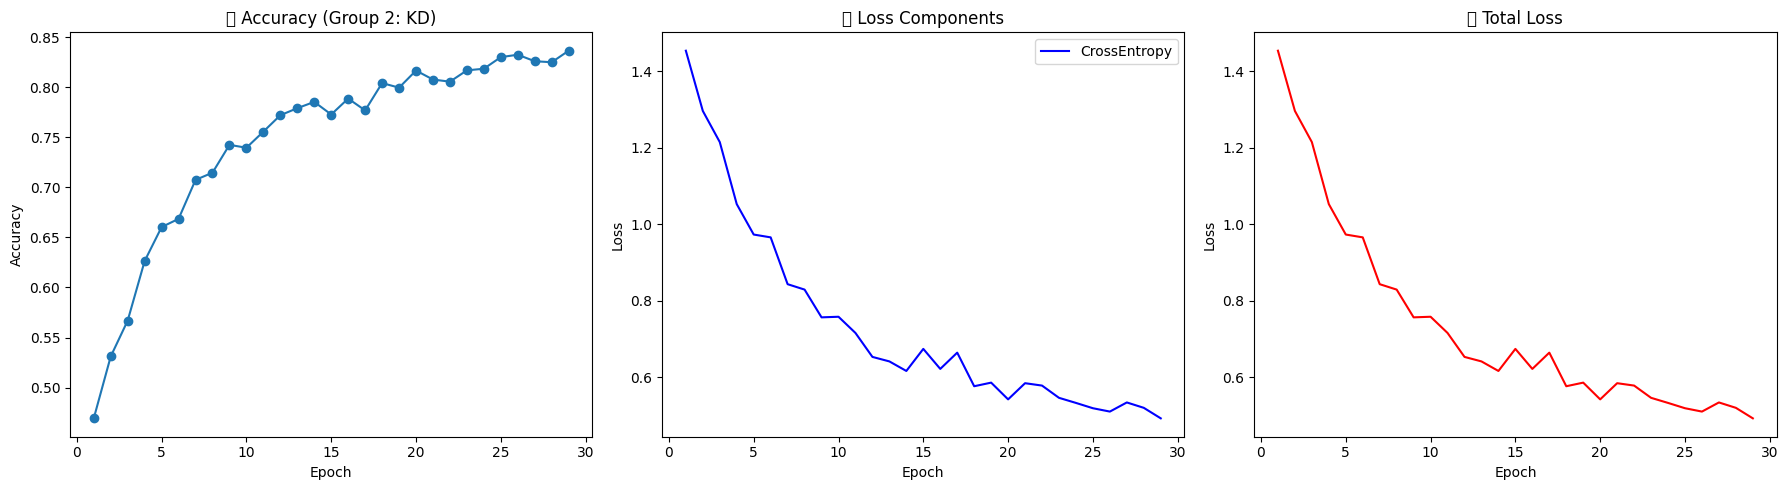

In [ ]:
# 🎓 KD Student with Early Stopping and Metrics
student_kd = StudentModel().to(device)
optimizer_kd = optim.SGD(student_kd.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
criterion_cls = nn.CrossEntropyLoss()
criterion_kd = nn.MSELoss()

epochs = 30
patience = 5
best_kd_acc = 0.0
epochs_no_improve = 0
best_epoch = 0

# 🧠 Metrics storage
kd_train_acc = []
group2_val_acc = []
group2_ce_loss = []
group2_total_loss = []

for epoch in range(epochs):
    print(f"\n🎓 KD Epoch {epoch + 1}/{epochs}")

    train_loss, train_acc = train_student_kd(
        student_kd, teacher, trainloader,
        criterion_cls, criterion_kd, optimizer_kd,
        alpha=0.5, device=device
    )
    val_loss, val_acc = evaluate(student_kd, testloader, criterion_cls, device)

    kd_train_acc.append(train_acc)
    group2_val_acc.append(val_acc)
    group2_ce_loss.append(val_loss)
    group2_total_loss.append(val_loss)  # אין רכיב KD בלוס הוולידציה שלנו בפונקציה הזו

    print(f"📊 Train Acc: {train_acc:.4f} | Test Acc: {val_acc:.4f}")

    # Early Stopping
    if val_acc > best_kd_acc:
        best_kd_acc = val_acc
        best_epoch = epoch
        epochs_no_improve = 0
        torch.save(student_kd.state_dict(), "best_student_kd.pth")
        print("💾 שמירה של המודל הטוב ביותר ✅")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"\n⏹️ עצירה מוקדמת ב־Epoch {epoch + 1} (לא חל שיפור במשך {patience} אפוקים)")
            break

kd_train_acc = kd_train_acc[:best_epoch + 1]
group2_val_acc = group2_val_acc[:best_epoch + 1]
group2_ce_loss = group2_ce_loss[:best_epoch + 1]
group2_total_loss = group2_total_loss[:best_epoch + 1]

# 🎨 Visualization: Accuracy, CE Loss, Total Loss
plt.figure(figsize=(18, 5))

# Accuracy
plt.subplot(1, 3, 1)
plt.plot(range(1, best_epoch + 2), group2_val_acc, marker='o')
plt.title("📈 Accuracy (Group 2: KD)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

# Loss components (only CE in validation)
plt.subplot(1, 3, 2)
plt.plot(range(1, best_epoch + 2), group2_ce_loss, label="CrossEntropy", color='blue')
plt.title("📉 Loss Components")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Total Loss (same as CE for validation)
plt.subplot(1, 3, 3)
plt.plot(range(1, best_epoch + 2), group2_total_loss, color='red')
plt.title("📉 Total Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.tight_layout()
plt.show()



Accuracy comparison graph of regular student vs. KD

/tmp/ipython-input-27-1319342699.py:24: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-27-1319342699.py:24: UserWarning: Glyph 127891 (\N{GRADUATION CAP}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-27-1319342699.py:24: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-27-1319342699.py:24: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127891 (\N{GRADUATION CAP}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py

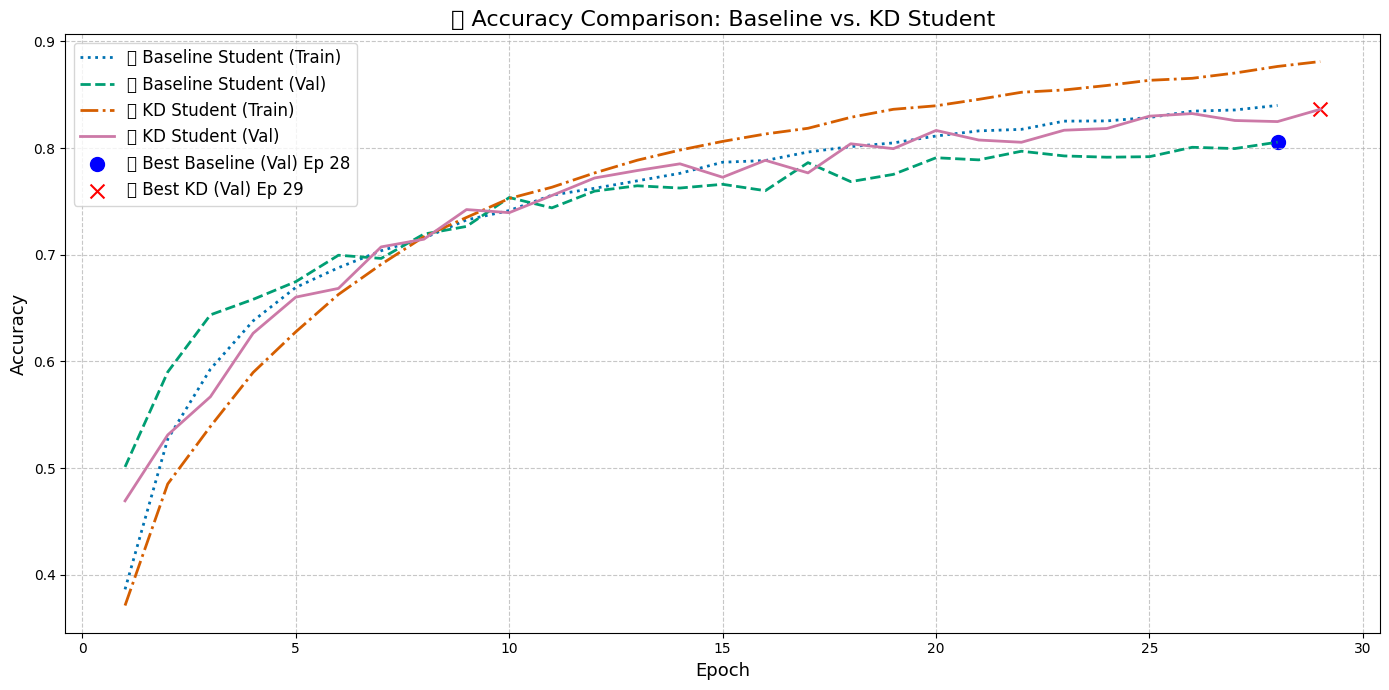

In [ ]:
plt.style.use('seaborn-v0_8-colorblind')
plt.figure(figsize=(14, 7))

# 🔹 Accuracy lines for the Baseline student
plt.plot(range(1, len(baseline_train_acc)+1), baseline_train_acc, label="🎓 Baseline Student (Train)", linestyle=':', linewidth=2)
plt.plot(range(1, len(baseline_val_acc)+1), baseline_val_acc, label="🎓 Baseline Student (Val)", linestyle='--', linewidth=2)

# 🔥 Accuracy lines for KD student
plt.plot(range(1, len(kd_train_acc)+1), kd_train_acc, label="🔥 KD Student (Train)", linestyle='-.', linewidth=2)
plt.plot(range(1, len(group2_val_acc)+1), group2_val_acc, label="🔥 KD Student (Val)", linestyle='-', linewidth=2)

# 🎯 Mark best epochs
best_base_epoch = baseline_val_acc.index(max(baseline_val_acc)) + 1
best_kd_epoch = group2_val_acc.index(max(group2_val_acc)) + 1
plt.scatter(best_base_epoch, baseline_val_acc[best_base_epoch - 1], color='blue', s=100, marker='o', label=f'🎯 Best Baseline (Val) Ep {best_base_epoch}')
plt.scatter(best_kd_epoch, group2_val_acc[best_kd_epoch - 1], color='red', s=100, marker='x', label=f'🎯 Best KD (Val) Ep {best_kd_epoch}')

# 🖼 General plot settings
plt.title("📊 Accuracy Comparison: Baseline vs. KD Student", fontsize=16)
plt.xlabel("Epoch", fontsize=13)
plt.ylabel("Accuracy", fontsize=13)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [ ]:
# Best accuracy values (define manually if not available)
best_baseline_train_acc = max(baseline_train_acc)
best_baseline_val_acc = max(baseline_val_acc)

best_kd_train_acc = max(kd_train_acc)
best_kd_val_acc = max(group2_val_acc)

# Table with best results
final_results = {
    "Model": ["Baseline Student", "KD Student"],
    "Best Train Accuracy": [
        round(best_baseline_train_acc, 4),
        round(best_kd_train_acc, 4)
    ],
    "Best Validation Accuracy": [
        round(best_baseline_val_acc, 4),
        round(best_kd_val_acc, 4)
    ]
}

results_df = pd.DataFrame(final_results)
display(results_df)


,Model,Best Train Accuracy,Best Validation Accuracy
0,Baseline Student,0.8400,0.8056
1,KD Student,0.8812,0.8364


 Group 3: KD + Alignment

In [ ]:
# Define student model, optimizer, and loss criterion
student_kd_align = StudentModel().to(device)
optimizer_align = torch.optim.SGD(student_kd_align.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
criterion_cls = nn.CrossEntropyLoss()

# Tracking lists for metrics
group3_train_acc = []
group3_val_acc = []
group3_ce_loss = []
group3_align_loss = []
group3_total_loss = []

# Early stopping parameters
patience = 7
early_stop_counter = 0
best_group3_acc = 0.0
best_epoch = 0
epochs = 30  # Make sure this is defined

# Training loop
for epoch in range(epochs):
    print(f"\nGroup 3 Epoch {epoch + 1}/{epochs}")

    student_kd_align.train()
    teacher.eval()

    total_correct = 0
    total_samples = 0
    running_loss_ce = 0.0
    running_loss_align = 0.0
    running_total_loss = 0.0

    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)

        with torch.no_grad():
            teacher_outputs, teacher_att = teacher(inputs)

        student_outputs, student_att = student_kd_align(inputs)

        # Classification loss
        loss_ce = criterion_cls(student_outputs, labels)

        # Feature alignment loss (cosine-normalized features)
        teacher_feat = teacher_att["layer3"].mean(dim=[2, 3])
        student_feat = student_att["layer3"].mean(dim=[2, 3])
        min_dim = min(teacher_feat.shape[1], student_feat.shape[1])
        teacher_feat = teacher_feat[:, :min_dim]
        student_feat = student_feat[:, :min_dim]
        teacher_feat = F.normalize(teacher_feat, p=2, dim=1)
        student_feat = F.normalize(student_feat, p=2, dim=1)

        loss_align = nn.MSELoss()(student_feat, teacher_feat)

        # Combined loss
        total_batch_loss = 0.5 * loss_ce + 0.5 * loss_align

        optimizer_align.zero_grad()
        total_batch_loss.backward()
        optimizer_align.step()

        _, preds = student_outputs.max(1)
        total_correct += preds.eq(labels).sum().item()
        total_samples += labels.size(0)
        running_loss_ce += loss_ce.item() * inputs.size(0)
        running_loss_align += loss_align.item() * inputs.size(0)
        running_total_loss += total_batch_loss.item() * inputs.size(0)

    # Compute averages for the epoch
    train_acc = total_correct / total_samples
    ce_avg = running_loss_ce / total_samples
    align_avg = running_loss_align / total_samples
    total_avg = running_total_loss / total_samples

    # Evaluate on validation set
    val_loss, val_acc = evaluate(student_kd_align, testloader, criterion_cls, device)

    # Store metrics
    group3_train_acc.append(train_acc)
    group3_val_acc.append(val_acc)
    group3_ce_loss.append(ce_avg)
    group3_align_loss.append(align_avg)
    group3_total_loss.append(total_avg)

    # Logging
    print(f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")
    print(f"Loss CE: {ce_avg:.4f} | Align: {align_avg:.4f} | Total: {total_avg:.4f}")

    # Early stopping check
    if val_acc > best_group3_acc:
        best_group3_acc = val_acc
        best_epoch = epoch + 1
        early_stop_counter = 0
        torch.save(student_kd_align.state_dict(), "best_group3_student.pth")
        print(f"New best model saved. Val Acc: {val_acc:.4f}")
    else:
        early_stop_counter += 1
        print(f"No improvement. Patience: {early_stop_counter}/{patience}")

    if early_stop_counter >= patience:
        print(f"\nEarly stopping triggered at epoch {epoch + 1}")
        break

# Final summary
print(f"\nBest Val Acc: {best_group3_acc:.4f} at Epoch {best_epoch}")



🔧 Group 3 Epoch 1/30


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


📊 Train Acc: 0.3671 | Val Acc: 0.4773
🧪 Loss CE: 1.7838 | Align: 0.0041 | Total: 0.8939
💾 New best model saved! Val Acc: 0.4773

🔧 Group 3 Epoch 2/30
📊 Train Acc: 0.4912 | Val Acc: 0.5226
🧪 Loss CE: 1.4007 | Align: 0.0041 | Total: 0.7024
💾 New best model saved! Val Acc: 0.5226

🔧 Group 3 Epoch 3/30
📊 Train Acc: 0.5448 | Val Acc: 0.5800
🧪 Loss CE: 1.2619 | Align: 0.0041 | Total: 0.6330
💾 New best model saved! Val Acc: 0.5800

🔧 Group 3 Epoch 4/30
📊 Train Acc: 0.5918 | Val Acc: 0.6047
🧪 Loss CE: 1.1415 | Align: 0.0041 | Total: 0.5728
💾 New best model saved! Val Acc: 0.6047

🔧 Group 3 Epoch 5/30
📊 Train Acc: 0.6276 | Val Acc: 0.6422
🧪 Loss CE: 1.0442 | Align: 0.0041 | Total: 0.5241
💾 New best model saved! Val Acc: 0.6422

🔧 Group 3 Epoch 6/30
📊 Train Acc: 0.6588 | Val Acc: 0.6869
🧪 Loss CE: 0.9649 | Align: 0.0041 | Total: 0.4845
💾 New best model saved! Val Acc: 0.6869

🔧 Group 3 Epoch 7/30
📊 Train Acc: 0.6857 | Val Acc: 0.7027
🧪 Loss CE: 0.8887 | Align: 0.0041 | Total: 0.4464
💾 New best m

/tmp/ipython-input-30-3659579531.py:22: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


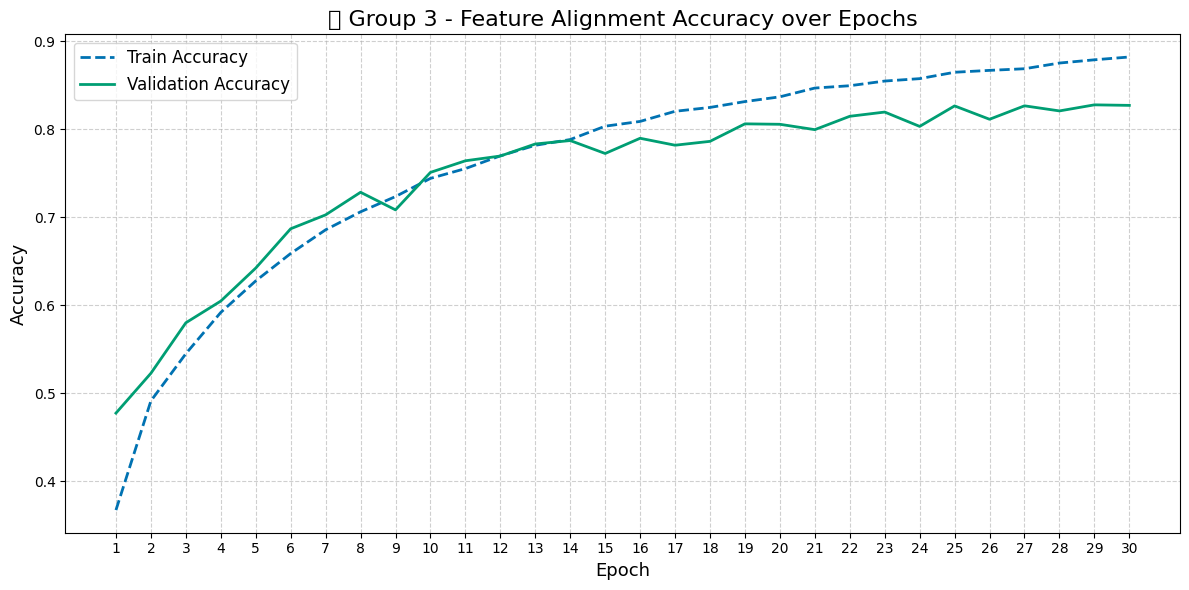

In [ ]:
# Determine how many epochs were actually run
epochs_ran = len(group3_train_acc)

# Create X-axis values
x = range(1, epochs_ran + 1)

# Plot accuracy curves
plt.style.use('seaborn-v0_8-colorblind')
plt.figure(figsize=(12, 6))

plt.plot(x, group3_train_acc, label="Train Accuracy", linestyle='--', linewidth=2)
plt.plot(x, group3_val_acc, label="Validation Accuracy", linestyle='-', linewidth=2)

plt.title("Group 3 - Feature Alignment Accuracy over Epochs", fontsize=16)
plt.xlabel("Epoch", fontsize=13)
plt.ylabel("Accuracy", fontsize=13)
plt.xticks(range(1, epochs_ran + 1))
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


Group 4: KD with Attention Transfer Only


In [ ]:
# Define attention loss function based on layer3
def attention_loss(student_att, teacher_att):
    s_feat = student_att["layer3"]
    t_feat = teacher_att["layer3"]

    # Match spatial size
    if s_feat.shape[2:] != t_feat.shape[2:]:
        s_feat = F.interpolate(s_feat, size=t_feat.shape[2:], mode='bilinear', align_corners=False)

    # Flatten and normalize using Frobenius norm
    def norm_att(x):
        return F.normalize(x.view(x.size(0), -1), p=2, dim=1)

    s_norm = norm_att(s_feat)
    t_norm = norm_att(t_feat)

    # Match channel dimensions
    min_dim = min(s_norm.shape[1], t_norm.shape[1])
    s_norm = s_norm[:, :min_dim]
    t_norm = t_norm[:, :min_dim]

    return F.mse_loss(s_norm, t_norm)

# Define model, optimizer, and loss
student_kd_att = StudentModel().to(device)
optimizer_att = torch.optim.SGD(student_kd_att.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
criterion_cls = nn.CrossEntropyLoss()

# Tracking metrics
group4_train_acc = []
group4_val_acc = []
group4_ce_loss = []
group4_att_loss = []
group4_total_loss = []

# Early stopping
patience = 7
early_stop_counter = 0
best_group4_acc = 0.0
best_epoch = 0
epochs = 30

# Training loop
for epoch in range(epochs):
    print(f"\nGroup 4 Epoch {epoch + 1}/{epochs}")

    student_kd_att.train()
    teacher.eval()

    running_loss = 0.0
    running_correct = 0
    total_samples = 0
    ce_loss_sum = 0.0
    att_loss_sum = 0.0

    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)

        with torch.no_grad():
            teacher_outputs, teacher_att = teacher(inputs)

        student_outputs, student_att = student_kd_att(inputs)

        # Compute losses
        loss_ce = criterion_cls(student_outputs, labels)
        loss_att = attention_loss(student_att, teacher_att)
        total_batch_loss = 0.5 * loss_ce + 0.5 * loss_att

        optimizer_att.zero_grad()
        total_batch_loss.backward()
        optimizer_att.step()

        _, preds = student_outputs.max(1)
        running_correct += preds.eq(labels).sum().item()
        total_samples += labels.size(0)
        running_loss += total_batch_loss.item() * inputs.size(0)
        ce_loss_sum += loss_ce.item() * inputs.size(0)
        att_loss_sum += loss_att.item() * inputs.size(0)

    # Compute epoch averages
    train_acc = running_correct / total_samples
    avg_total_loss = running_loss / total_samples
    avg_ce_loss = ce_loss_sum / total_samples
    avg_att_loss = att_loss_sum / total_samples

    # Validation
    val_loss, val_acc = evaluate(student_kd_att, testloader, criterion_cls, device)

    # Save results
    group4_train_acc.append(train_acc)
    group4_val_acc.append(val_acc)
    group4_ce_loss.append(avg_ce_loss)
    group4_att_loss.append(avg_att_loss)
    group4_total_loss.append(avg_total_loss)

    # Logging
    print(f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")
    print(f"Losses => CE: {avg_ce_loss:.4f} | Attention: {avg_att_loss:.4f} | Total: {avg_total_loss:.4f}")

    # Early stopping check
    if val_acc > best_group4_acc:
        best_group4_acc = val_acc
        best_epoch = epoch + 1
        early_stop_counter = 0
        torch.save(student_kd_att.state_dict(), "best_group4_student.pth")
        print(f"New best model saved. Val Acc: {val_acc:.4f}")
    else:
        early_stop_counter += 1
        print(f"No improvement. Patience: {early_stop_counter}/{patience}")

    if early_stop_counter >= patience:
        print(f"\nEarly stopping triggered at epoch {epoch + 1}")
        break

# Final summary
print(f"\nBest Val Acc: {best_group4_acc:.4f} at Epoch {best_epoch}")



🌐 Group 4 Epoch 1/30


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


📊 Train Acc: 0.3668 | Val Acc: 0.4652
🧪 Losses => CE: 1.7853 | Attention: 0.0009 | Total: 0.8931
💾 New best model saved! Val Acc: 0.4652

🌐 Group 4 Epoch 2/30
📊 Train Acc: 0.4848 | Val Acc: 0.5436
🧪 Losses => CE: 1.4155 | Attention: 0.0009 | Total: 0.7082
💾 New best model saved! Val Acc: 0.5436

🌐 Group 4 Epoch 3/30
📊 Train Acc: 0.5406 | Val Acc: 0.5565
🧪 Losses => CE: 1.2700 | Attention: 0.0009 | Total: 0.6355
💾 New best model saved! Val Acc: 0.5565

🌐 Group 4 Epoch 4/30
📊 Train Acc: 0.5879 | Val Acc: 0.6138
🧪 Losses => CE: 1.1460 | Attention: 0.0009 | Total: 0.5735
💾 New best model saved! Val Acc: 0.6138

🌐 Group 4 Epoch 5/30
📊 Train Acc: 0.6226 | Val Acc: 0.6467
🧪 Losses => CE: 1.0543 | Attention: 0.0009 | Total: 0.5276
💾 New best model saved! Val Acc: 0.6467

🌐 Group 4 Epoch 6/30
📊 Train Acc: 0.6533 | Val Acc: 0.6641
🧪 Losses => CE: 0.9735 | Attention: 0.0009 | Total: 0.4872
💾 New best model saved! Val Acc: 0.6641

🌐 Group 4 Epoch 7/30
📊 Train Acc: 0.6821 | Val Acc: 0.6981
🧪 Losses

/tmp/ipython-input-32-1982101848.py:22: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


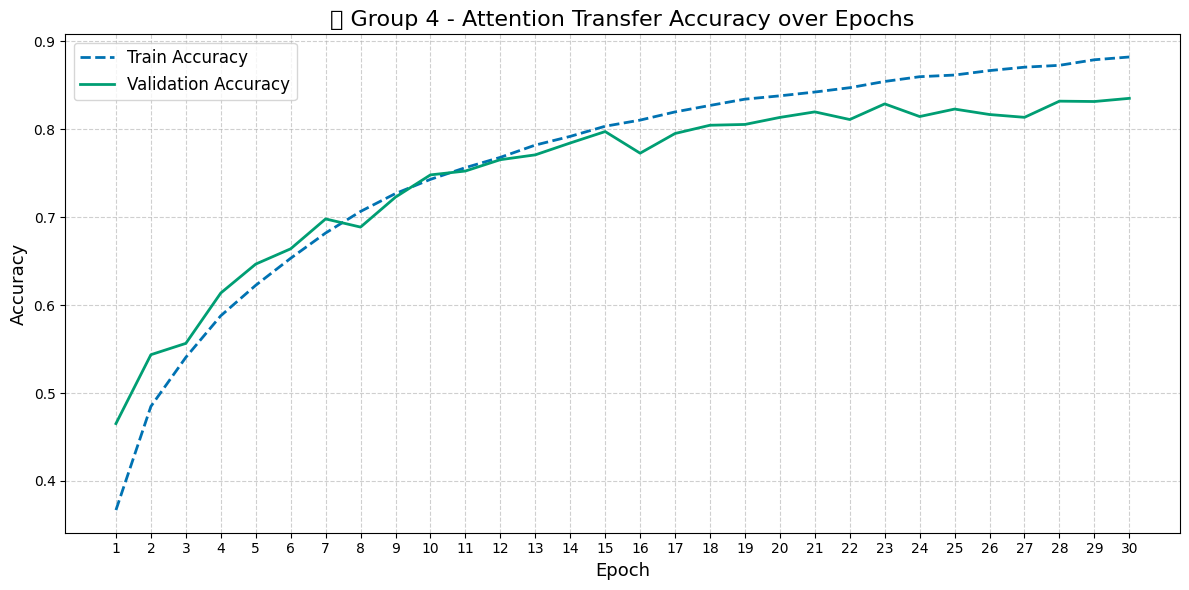

In [ ]:
# Determine the number of epochs actually run
epochs_ran = len(group4_train_acc)

# Create the X-axis values
x = range(1, epochs_ran + 1)

# Accuracy plot
plt.style.use('seaborn-v0_8-colorblind')
plt.figure(figsize=(12, 6))

plt.plot(x, group4_train_acc, label="Train Accuracy", linestyle='--', linewidth=2)
plt.plot(x, group4_val_acc, label="Validation Accuracy", linestyle='-', linewidth=2)

plt.title("Group 4 - Attention Transfer Accuracy over Epochs", fontsize=16)
plt.xlabel("Epoch", fontsize=13)
plt.ylabel("Accuracy", fontsize=13)
plt.xticks(range(1, epochs_ran + 1))
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


/tmp/ipython-input-33-2916267749.py:24: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-33-2916267749.py:24: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-33-2916267749.py:24: UserWarning: Glyph 128301 (\N{TELESCOPE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128301 (\N{TELESCOPE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


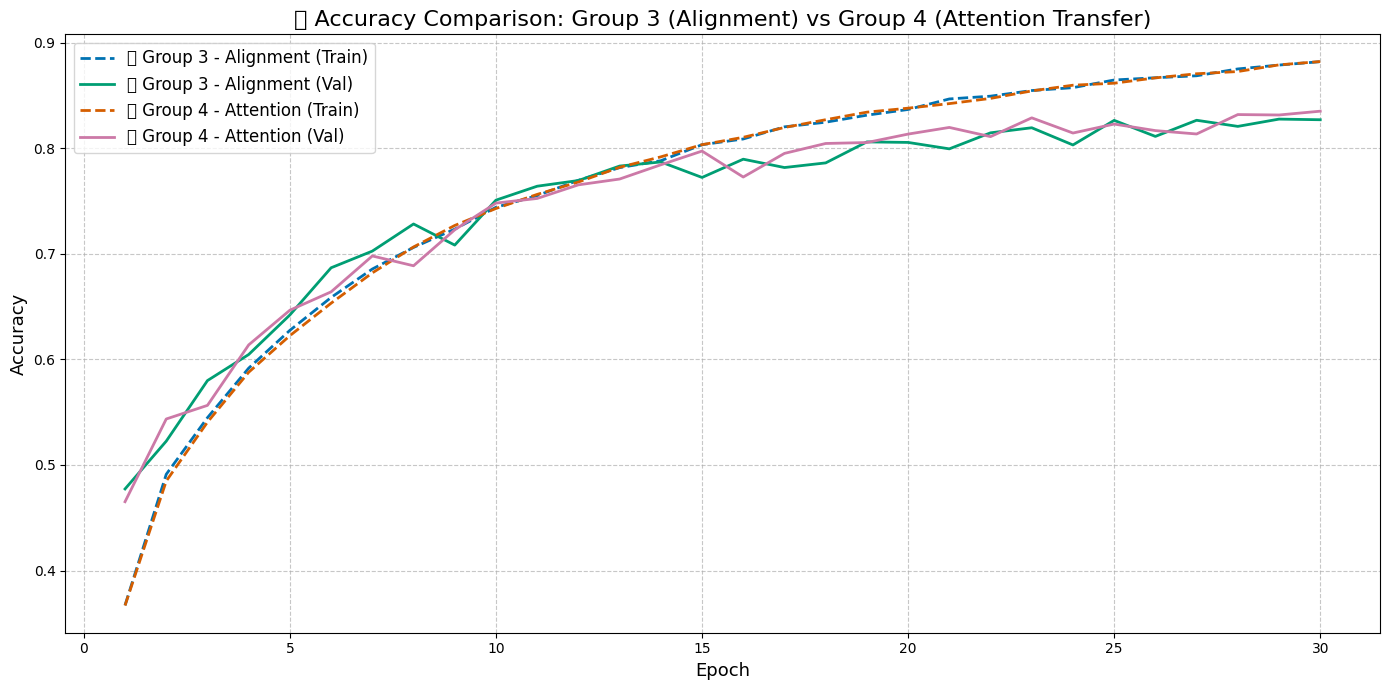

In [ ]:
# Accuracy comparison between Group 3 (Alignment) and Group 4 (Attention Transfer)
min_len = min(len(group3_train_acc), len(group4_train_acc),
              len(group3_val_acc), len(group4_val_acc))
x = range(1, min_len + 1)

plt.style.use('seaborn-v0_8-colorblind')
plt.figure(figsize=(14, 7))

# Group 3 – KD + Alignment
plt.plot(x, group3_train_acc[:min_len], label="Group 3 - Alignment (Train)", linestyle='--', linewidth=2)
plt.plot(x, group3_val_acc[:min_len], label="Group 3 - Alignment (Val)", linestyle='-', linewidth=2)

# Group 4 – KD + Attention Transfer
plt.plot(x, group4_train_acc[:min_len], label="Group 4 - Attention (Train)", linestyle='--', linewidth=2)
plt.plot(x, group4_val_acc[:min_len], label="Group 4 - Attention (Val)", linestyle='-', linewidth=2)

plt.title("Accuracy Comparison: Group 3 (Alignment) vs Group 4 (Attention Transfer)", fontsize=16)
plt.xlabel("Epoch", fontsize=13)
plt.ylabel("Accuracy", fontsize=13)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [ ]:
# Find the epochs with the highest validation accuracy for each group
best_epoch_group3 = max(enumerate(group3_val_acc), key=lambda x: x[1])[0]
best_epoch_group4 = max(enumerate(group4_val_acc), key=lambda x: x[1])[0]

# Create a table with results from the best epochs
best_results_df = pd.DataFrame({
    'Model': ['Group 3 (Align)', 'Group 4 (Attention)'],
    'Epoch': [best_epoch_group3 + 1, best_epoch_group4 + 1],
    'Train Accuracy': [group3_train_acc[best_epoch_group3], group4_train_acc[best_epoch_group4]],
    'Val Accuracy': [group3_val_acc[best_epoch_group3], group4_val_acc[best_epoch_group4]],
})

# Display the table
display(best_results_df)

# Save the table (optional)
# best_results_df.to_csv("best_epoch_comparison_group3_vs_group4.csv", index=False)


,Model,Epoch,Train Accuracy,Val Accuracy
0,Group 3 (Align),29,0.87902,0.8278
1,Group 4 (Attention),30,0.88236,0.8353


Group 5: Combined Method (KD + FA + AT)


In [ ]:
def train_student_kd_combined(student, teacher, dataloader, criterion_cls, optimizer,
                              alpha=0.5, beta=0.25, device="cuda"):
    """
    Train student with combined KD loss:
    - alpha: weight for classification loss
    - beta: weight for feature alignment loss
    - gamma = 1 - alpha - beta: weight for attention transfer loss
    """
    student.train()
    teacher.eval()

    gamma = 1 - alpha - beta
    criterion_kd = nn.MSELoss()

    total_correct = 0
    total_samples = 0
    total_loss = 0.0

    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        with torch.no_grad():
            teacher_outputs, teacher_att = teacher(inputs)

        student_outputs, student_att = student(inputs)

        # Loss 1: Classification (cross entropy)
        loss_cls = criterion_cls(student_outputs, labels)

        # Loss 2: Feature Alignment (mean over spatial dimensions + L2 normalization)
        teacher_feat = teacher_att["layer3"].mean(dim=[2, 3])
        student_feat = student_att["layer3"].mean(dim=[2, 3])
        min_dim = min(teacher_feat.shape[1], student_feat.shape[1])
        teacher_feat = teacher_feat[:, :min_dim]
        student_feat = student_feat[:, :min_dim]

        teacher_feat = F.normalize(teacher_feat, p=2, dim=1)
        student_feat = F.normalize(student_feat, p=2, dim=1)
        loss_feat = criterion_kd(student_feat, teacher_feat)

        # Loss 3: Attention Transfer (spatial map flattened + normalized)
        t_att = teacher_att["layer3"]
        s_att = student_att["layer3"]

        if s_att.shape[2:] != t_att.shape[2:]:
            s_att = F.interpolate(s_att, size=t_att.shape[2:], mode='bilinear', align_corners=False)

        def norm_att(x):
            return F.normalize(x.view(x.size(0), -1), p=2, dim=1)

        s_norm = norm_att(s_att)
        t_norm = norm_att(t_att)

        min_c = min(s_norm.shape[1], t_norm.shape[1])
        loss_att = criterion_kd(s_norm[:, :min_c], t_norm[:, :min_c])

        # Combined weighted loss
        total_batch_loss = alpha * loss_cls + beta * loss_feat + gamma * loss_att

        optimizer.zero_grad()
        total_batch_loss.backward()
        optimizer.step()

        _, preds = student_outputs.max(1)
        total_correct += preds.eq(labels).sum().item()
        total_samples += labels.size(0)
        total_loss += total_batch_loss.item() * inputs.size(0)

    avg_loss = total_loss / total_samples
    acc = total_correct / total_samples
    return avg_loss, acc, loss_cls.item(), loss_feat.item(), loss_att.item()


In [ ]:
# Model, optimizer, and loss definition
student_kd_combined = StudentModel().to(device)
optimizer_combined = torch.optim.SGD(student_kd_combined.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
criterion_cls = nn.CrossEntropyLoss()

# Accuracy tracking
group5_train_acc = []
group5_val_acc = []

# Early stopping setup
patience = 7
early_stop_counter = 0
best_combined_acc = 0.0
best_epoch = 0

# Training loop
alpha = 0.5
beta = 0.25
gamma = 1 - alpha - beta
epochs = 30

for epoch in range(epochs):
    print(f"\nGroup 5 Epoch {epoch + 1}/{epochs}")
    
    train_loss, train_acc, loss_ce, loss_feat, loss_att = train_student_kd_combined(
        student_kd_combined, teacher, trainloader,
        criterion_cls, optimizer_combined,
        alpha=alpha, beta=beta, device=device
    )
    
    val_loss, val_acc = evaluate(student_kd_combined, testloader, criterion_cls, device)

    group5_train_acc.append(train_acc)
    group5_val_acc.append(val_acc)

    print(f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")
    print(f"Losses | CE: {loss_ce:.4f}, Feat: {loss_feat:.4f}, Att: {loss_att:.4f}, Total: {train_loss:.4f}")

    if val_acc > best_combined_acc:
        best_combined_acc = val_acc
        best_epoch = epoch + 1
        early_stop_counter = 0
        torch.save(student_kd_combined.state_dict(), "best_student_combined.pth")
        print(f"New best model saved. Val Acc: {val_acc:.4f}")
    else:
        early_stop_counter += 1
        print(f"No improvement. Patience: {early_stop_counter}/{patience}")

    if early_stop_counter >= patience:
        print(f"\nEarly stopping triggered at epoch {epoch + 1}")
        break

# Final summary
print(f"\nBest Val Acc: {best_combined_acc:.4f} at Epoch {best_epoch}")



🔬 Group 5 Epoch 1/30


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


📊 Train Acc: 0.3655 | Val Acc: 0.4703
🧪 Losses | CE: 1.2513, Feat: 0.0041, Att: 0.0009, Total: 0.8959
💾 New best model saved! Val Acc: 0.4703

🔬 Group 5 Epoch 2/30
📊 Train Acc: 0.4921 | Val Acc: 0.5461
🧪 Losses | CE: 1.3072, Feat: 0.0041, Att: 0.0009, Total: 0.7019
💾 New best model saved! Val Acc: 0.5461

🔬 Group 5 Epoch 3/30
📊 Train Acc: 0.5465 | Val Acc: 0.5824
🧪 Losses | CE: 1.1282, Feat: 0.0041, Att: 0.0009, Total: 0.6294
💾 New best model saved! Val Acc: 0.5824

🔬 Group 5 Epoch 4/30
📊 Train Acc: 0.5943 | Val Acc: 0.6013
🧪 Losses | CE: 1.1503, Feat: 0.0041, Att: 0.0009, Total: 0.5670
💾 New best model saved! Val Acc: 0.6013

🔬 Group 5 Epoch 5/30
📊 Train Acc: 0.6297 | Val Acc: 0.6605
🧪 Losses | CE: 0.9841, Feat: 0.0041, Att: 0.0009, Total: 0.5181
💾 New best model saved! Val Acc: 0.6605

🔬 Group 5 Epoch 6/30
📊 Train Acc: 0.6601 | Val Acc: 0.6752
🧪 Losses | CE: 0.7512, Feat: 0.0041, Att: 0.0009, Total: 0.4778
💾 New best model saved! Val Acc: 0.6752

🔬 Group 5 Epoch 7/30
📊 Train Acc: 0.6

/tmp/ipython-input-37-1208109386.py:19: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


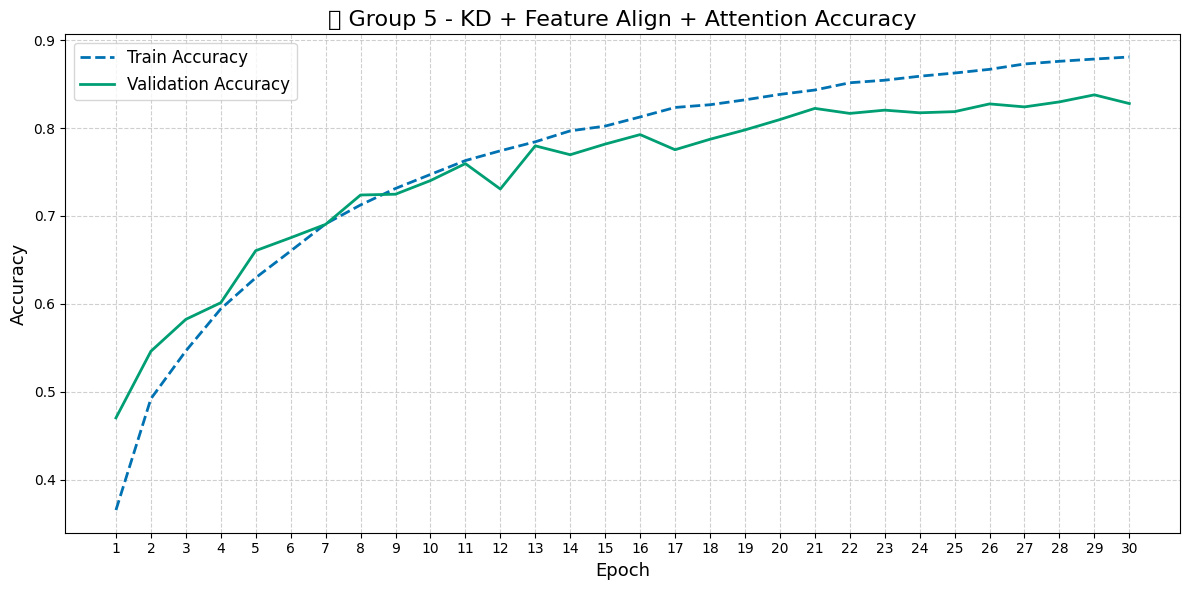

In [ ]:
# Create accuracy plot for Group 5 (Combined KD: CE + Feature Align + Attention)
epochs_ran = len(group5_train_acc)
x = range(1, epochs_ran + 1)

plt.style.use('seaborn-v0_8-colorblind')
plt.figure(figsize=(12, 6))

plt.plot(x, group5_train_acc, label="Train Accuracy", linestyle='--', linewidth=2)
plt.plot(x, group5_val_acc, label="Validation Accuracy", linestyle='-', linewidth=2)

plt.title("Group 5 - KD + Feature Alignment + Attention Accuracy", fontsize=16)
plt.xlabel("Epoch", fontsize=13)
plt.ylabel("Accuracy", fontsize=13)
plt.xticks(range(1, epochs_ran + 1))
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


,Group,Best Validation Accuracy
0,Group 1: Baseline,0.8056
1,Group 2: KD,0.8364
2,Group 3: Feature Alignment,0.8278
3,Group 4: Attention Transfer,0.8353
4,Group 5: Combined (Align + Attention),0.8377


/tmp/ipython-input-38-2670410714.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x="Group", y="Best Validation Accuracy", palette="viridis")
/tmp/ipython-input-38-2670410714.py:38: UserWarning: Glyph 128285 (\N{TOP WITH UPWARDS ARROW ABOVE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128285 (\N{TOP WITH UPWARDS ARROW ABOVE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


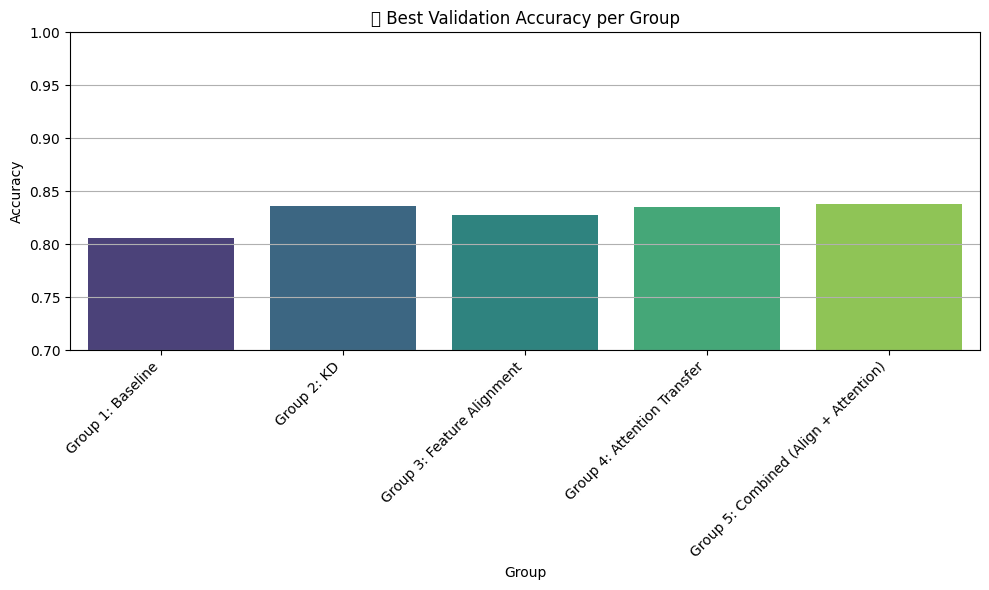

In [ ]:
# Best validation accuracy values for each group (manually collected)
results = {
    "Group": [
        "Group 1: Baseline",
        "Group 2: KD",
        "Group 3: Feature Alignment",
        "Group 4: Attention Transfer",
        "Group 5: Combined (Align + Attention)"
    ],
    "Best Validation Accuracy": [
        max(baseline_val_acc),
        max(group2_val_acc),
        max(group3_val_acc),
        max(group4_val_acc),
        max(group5_val_acc)
    ]
}

# Create DataFrame
results_df = pd.DataFrame(results)

# Display table

display(results_df)

# Bar plot of best validation accuracy per group
plt.figure(figsize=(10, 6))
sns.barplot(data=results_df, x="Group", y="Best Validation Accuracy", palette="viridis")
plt.title("Best Validation Accuracy per Group")
plt.ylabel("Accuracy")
plt.ylim(0.7, 1.0)
plt.xticks(rotation=45, ha="right")
plt.grid(axis='y')
plt.tight_layout()
plt.show()
